In [1]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json

## EDA

In [2]:
recipe_sources = ['ar', 'epi','fn']

In [ ]:
temp = json.load(open('/content/recipes_raw_nosource_ar.json','r'))
temp

In [11]:
df = pd.DataFrame()
sources, titles, ingredients, instructions = [], [], [], []
for recipe_source in recipe_sources:
    data = json.load(open(f'/content/recipes_raw_nosource_{recipe_source}.json', 'r'))
    for _, recipe in data.items():
        if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
            sources.append(recipe_source)  
            titles.append(recipe['title'])      
            ingredients.append([str(ingr) for ingr in recipe['ingredients'] if ingr!='ADVERTISEMENT']) 
            instructions.append(str(recipe['instructions']).replace('ADVERTISEMENT','').replace('\n',''))
df['source'] = sources
df['title'] = titles
df['ingredients'] = ingredients
df['instructions'] = instructions

In [12]:
df.head()

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...


In [13]:
to_remove = [
    'tablespoon','tablespoons','teaspoon','teaspoons',
    'tsp','tsps','tbsp','tbsps','pound','pounds',
    'grams','mg','ounce''ounces','kg','crushed',
    'chopped','finely','softened','cups','cup'
]
translation_table = str.maketrans('','',string.punctuation+string.digits)

In [14]:
def preprocess(items):
  res = []
  for i, item in enumerate(items):
    temp = item.lower().replace('-',' ')
    temp = temp.translate(translation_table)
    temp = remove_stopwords(temp)
    for stop_word in to_remove:
      temp = temp.replace(stop_word, '')
    res.append(temp.split())
  return res

In [16]:
instructions = df.instructions.values.tolist()
ingredients = [', '.join(i) for i in df.ingredients.values.tolist()]

In [17]:
train_data = preprocess(instructions + ingredients)

In [21]:
with open('/content/train_data.pkl', 'wb') as f:
  pickle.dump(train_data,f)

## Word2vec

In [23]:
from gensim.models.word2vec import Word2Vec

In [24]:
model = Word2Vec()

model.build_vocab(train_data)

In [27]:
%%time
model.train(train_data, total_examples=model.corpus_count, 
            epochs = model.epochs)

CPU times: user 3min 38s, sys: 896 ms, total: 3min 39s
Wall time: 1min 53s


(67964826, 81996930)

In [47]:
try:
  print(*model.wv.most_similar(['orange'], topn = 20), sep = '\n')
except KeyError as e:
  print(f'The ingredient not in the list ({str(e)}).')

('tangerine', 0.8844500184059143)
('lemon', 0.8269450664520264)
('clementine', 0.7914227843284607)
('citrus', 0.7482976913452148)
('grapefruit', 0.7286081314086914)
('satsuma', 0.7212076783180237)
('lime', 0.7088994979858398)
('limes', 0.6737093925476074)
('tangelo', 0.6602089405059814)
('tangerines', 0.6413543224334717)
('lemons', 0.6404346227645874)
('oranges', 0.6371762752532959)
('yuzu', 0.6045023202896118)
('clementines', 0.5891534090042114)
('pineapple', 0.5866617560386658)
('extractor', 0.5537314414978027)
('pomegranate', 0.544706404209137)
('emon', 0.5357046127319336)
('apple', 0.5227352380752563)
('kumquat', 0.5181835889816284)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Results

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [51]:
with open('/content/items_for_sale.txt','r') as f:
  items_for_sale = f.read().split('\n')

items_for_sale[:5]

['salt', 'pepper', 'fresh', 'oil', 'sugar']

In [52]:
words, vectors = [],[]
for item in items_for_sale:
  try:
    vectors.append(model.wv.get_vector(item))
    words.append(item)
  except KeyError as e:
    print('Not found')

In [53]:
vectors[0]

array([-1.2503681 , -2.3000314 ,  1.3105842 ,  0.44794148,  2.0273228 ,
       -2.501133  , -0.82536227,  2.248839  , -0.5088767 ,  1.017733  ,
       -0.936727  ,  2.581491  , -2.3961623 ,  0.3121697 , -2.0187864 ,
       -0.72237647, -0.34622753, -0.04261944,  0.99243987,  3.724108  ,
        2.2593248 , -1.7718651 ,  1.4715282 , -0.27701443, -3.5373633 ,
       -0.02612181, -2.7941086 ,  1.4699851 ,  1.2070311 ,  2.9987547 ,
        5.369668  , -0.29096955,  3.096456  , -2.2552106 ,  0.9809803 ,
        0.83035755, -0.592995  , -1.9773564 , -0.9428718 , -3.6601713 ,
       -0.08732396, -2.3152914 ,  1.5925027 ,  4.319083  , -1.9513032 ,
        0.443147  , -0.44963607, -0.30167946, -0.67255616,  2.1585767 ,
       -2.28301   ,  1.1514611 ,  1.3487513 , -0.8489407 ,  0.48071823,
       -0.6677648 , -0.41976202,  0.63602084, -0.8562882 ,  0.96987677,
       -2.092464  , -0.3394428 , -1.348504  ,  0.69605833,  0.93396527,
        4.016599  ,  0.09355919,  1.2736329 , -0.6851595 , -3.29

In [54]:
sims = cosine_similarity(vectors,vectors)

In [56]:
for i in range(len(vectors)):
  sims[i,i] = False

In [63]:
k = 20
indices = list(range(len(vectors)))

random.shuffle(indices)

indices = indices[:k]

In [64]:
small_vectors = [vectors[i] for i in indices]
small_words = [words[i] for i in indices]

small_sims = cosine_similarity(small_vectors,small_vectors)
for i in range(len(small_vectors)):
  small_sims[i,i] = False

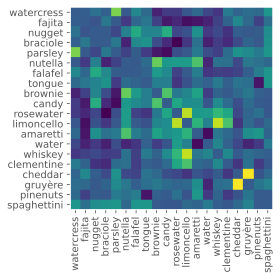

In [65]:
fig, ax = plt.subplots()
im = ax.imshow(small_sims)

ax.set_xticks(np.arange(len(small_vectors)))
ax.set_yticks(np.arange(len(small_vectors)))

ax.set_xticklabels(small_words)
ax.set_yticklabels(small_words)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

## Visualization w/ Plotly

In [67]:
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx

In [69]:
indices = np.argwhere(sims>0.6)

In [74]:
G = nx.Graph()

for index in indices:
  G.add_edge(words[index[0]], words[index[1]], 
             weight = sims[index[0],index[1]])

In [77]:
weight_values = nx.get_edge_attributes(G, 'weight')
weight_values[('eggs','egg')]

0.77520424

In [79]:
positions = nx.spring_layout(G)

In [80]:
nx.set_node_attributes(G, name = 'position', values = positions)

In [85]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    opacity=0.7,
    line=dict(width=2, color='White'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    sizes.append(20)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True, line=dict(color='White'),
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Picnic',reversescale=False,color=[],opacity=0.9,size=sizes,
        colorbar=dict(thickness=15,title='Node Connections',xanchor='left', titleside='right'),
        line_width=2
    )
)

invisible_similarity_trace = go.Scatter(
    x=ave_x, y=ave_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        opacity=0,
    )
)

invisible_similarity_trace.text=weights

In [86]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [87]:
fig = go.Figure(
    data=[edge_trace, node_trace, invisible_similarity_trace],
    layout=go.Layout(
        title='Network Graph of Word Embeddings',
        template='plotly_dark',
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) 
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

plot(fig)

'temp-plot.html'